In [49]:
from PIL import Image                      
import os, glob, numpy as np
from sklearn.model_selection import train_test_split #from 모듈이름 import 함수이름을 만들어 작성시작한다.
                                                        #파이썬이라 맨윗줄에 함수를 넣어 작성해야됨

caltech_dir = "C:/gunjong/dog"  #caltect_dir에 자신이 쓸 디렉토리를 입력한다(정확한 주소입력)
categories = ["doberman1","sichu1"] #"C:/gunjong/dog" 해당주소안의 정확한 파일이름 작성
nb_classes = len(categories)

image_w = 64  #이미지 크기는 64 x 64 로 만든다
image_h = 64

pixels = image_h * image_w * 3  # *3으로 한것은 RGB 채널이 3채널이기 때문
                                                                        

X = []
y = []

for idx, cat in enumerate(categories): #이미지 파일을 RGB값으로 바꾸면서 RESIZE 해주고 그 값을 numpy 파일로 저장해주는 코딩
    
    
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 doberman
#0 1 0 0 이면 sichu 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./multi_image_data.npy", xy)  #해당 주소로 저장

print("ok", len(y))

doberman1  파일 길이 :  1906
doberman1  :  C:/gunjong/dog/doberman1\cat_0_1085.jpg
doberman1  :  C:/gunjong/dog/doberman1\dober_0_3908.jpg
doberman1  :  C:/gunjong/dog/doberman1\dober_0_7405.jpg
sichu1  파일 길이 :  2000
sichu1  :  C:/gunjong/dog/sichu1\1 - 1000656188.jpg
sichu1  :  C:/gunjong/dog/sichu1\21 - 523674503.jpg
sichu1  :  C:/gunjong/dog/sichu1\4 - 1222292354.jpg
ok 3906


In [50]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K  #여기부분은 딱히 설명안해주셔도 됩니다

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)#여기부분은 딱히 설명안해주셔도 됩니다

X_train, X_test, y_train, y_test = np.load('./multi_image_data.npy', allow_pickle=True)#해당 주소 가져온다
print(X_train.shape)#이미지 크기 , 이미지 64X64로 만들었는지 확인 , RGB값 3채널인지 확인
print(X_train.shape[0])

(2929, 64, 64, 3)
2929


In [51]:
categories = ["doberman1","sichu1"] #CNN 컨볼루션 신경망 모델 만들기
nb_classes = len(categories)        #Con2D 로 만들수 있다

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [52]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model' # 모델을 패치하고 난 NUMPY값 저장
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [53]:
model.summary() # 모델의 구조를 요약해 출력한다. 이때까지 코딩한 CONV2D 나 , 이미지 크기설정 등등 확인가능

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16384)            

In [54]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])
#해당주소 이미지파일들을 강화학습 시켜 견종을 분류시키기 위한 강화학습코드

Epoch 1/50
92/92 [==============================] - ETA: 0s - loss: 0.7609 - accuracy: 0.6176
Epoch 00001: val_loss improved from inf to 0.43648, saving model to ./model\multi_img_classification.model
INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets
92/92 [==============================] - 12s 134ms/step - loss: 0.7609 - accuracy: 0.6176 - val_loss: 0.4365 - val_accuracy: 0.8444
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 0.3835 - accuracy: 0.8484
Epoch 00002: val_loss improved from 0.43648 to 0.29924, saving model to ./model\multi_img_classification.model
INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets
92/92 [==============================] - 12s 130ms/step - loss: 0.3835 - accuracy: 0.8484 - val_loss: 0.2992 - val_accuracy: 0.8833
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.8901
Epoch 00003: val_loss improved from 0.29924 to 0.24337, saving model to ./

In [55]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))
# 정확도가 얼마인지 알아봅시다

31/31 [==============================] - 1s 23ms/step - loss: 0.1287 - accuracy: 0.9652
정확도 : 0.9652


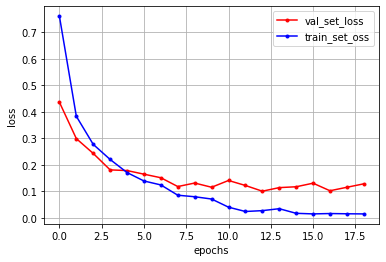

In [56]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()
#해당 강화학습이 얼만큼 안정성을 찾았는지에 대해 알아봅시다.

In [57]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "C:/gunjong/test/test1/test2" #견종분류 예시용 디렉토리 파일 주소
image_w = 64
image_h = 64 #해당 이미지 크기는 위와 동일한 64 X 64 크기로 설정

pixels = image_h * image_w * 3 # *3으로 한것은 RGB 채널이 3채널이기 때문

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.jpg")
for i, f in enumerate(files):  #이미지 파일을 RGB값으로 바꾸면서 RESIZE 해주고 그 값을 numpy 파일로 저장해주는 코드
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data) 

X = np.array(X)
model = load_model('./model/multi_img_classification.model')# 모델을 패치하고 난 NUMPY값 출력

prediction = model.predict(X) # data를 넣어 결과를 예측시킨다. → predict() 메서드 
                              # 분류작업을 위해 가장 중요한 메서드 이다.
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

for i in prediction: #강화학습이 끝나고 분류작업을 하기위한 코드 작성
    pre_ans = i.argmax()  # 예측 레이블

    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "도베르만"
    else : pre_ans_str = "시츄"
        
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
                            
    cnt += 1

해당 doberman (1).jpg이미지는 도베르만로 추정됩니다.
해당 doberman (2).jpg이미지는 시츄으로 추정됩니다.
해당 doberman (3).jpg이미지는 도베르만로 추정됩니다.
해당 doberman (4).jpg이미지는 도베르만로 추정됩니다.
해당 doberman (5).jpg이미지는 도베르만로 추정됩니다.
해당 sichu (1).jpg이미지는 시츄으로 추정됩니다.
해당 sichu (2).jpg이미지는 시츄으로 추정됩니다.
해당 sichu (3).jpg이미지는 시츄으로 추정됩니다.
해당 sichu (4).jpg이미지는 시츄으로 추정됩니다.
해당 sichu (5).jpg이미지는 시츄으로 추정됩니다.
